# A Simple Autoencoder for Anomaly Detection

Anomaly detection is the task of finding anomalous data elements in a dataset. An anomaly is a data element that is an outlier with respect to the rest of the dataset.

We are going to train an autoencoder on the MNIST dataset (that only contains numbers), and then we will look into anomalies within the MNIST dataset (i.e., images within MNIST that are somehow different than the rest of the dataset).

Even though MNIST is a labeled dataset, we are going to disregard the labels for educational purposes and consider it as an unlabeled dataset.

In [1]:
!pip install -r requirements.txt | grep -v "already"

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for bokeh: filename=bokeh-2.1.1-py3-none-any.whl size=9257186 sha256=b0392ddb762dbb26849279f2a8fff49f2e73b9bbee025d4c3ed71df1a6c38100
  Stored in directory: /root/.cache/pip/wheels/f7/55/ff/f3d7554e69382d31cf7ad857cf518af9b923134fca7d925187
Successfully built bokeh
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


> After installing the dependencies you need to restart your kernel. The following cell does that for you.

In [2]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

{'status': 'ok', 'restart': True}

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
from helpers import get_data_loaders
from helpers import seed_all
from helpers import anomaly_detection_display
import pandas as pd

# Ensure repeatibility
seed_all(42)

In [2]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=1024)

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


### Visualize the Data

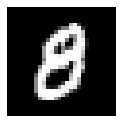

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize = (2,2)) 
sub.imshow(img, cmap='gray')
_ = sub.axis("off")

---
## Linear Autoencoder

We'll train an autoencoder with these images by flattening them into vectors of length 784. The images from this dataset are already normalized such that the values are between 0 and 1. 

Here you will build a simple autoencoder. 

The encoder and decoder should be made of simple Multi-Layer Perceptrons. The units that connect the encoder and decoder will be the _compressed representation_ (also called _embedding_).

Since the images are normalized between 0 and 1, you will need to use a **sigmoid activation on the output layer** to get values that match this input value range.

For this exercise you are going to use a dimension for the embeddings of 32.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # Implement an MLP with an input size of 28*28, and an 
        # output layer of size encoding_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, encoding_dim),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim)
        )
        
        ## decoder ##
        # Implement an MLP with an input layer of size encoding_dim
        # and an output layer of size 28*28
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 28 * 28),
            nn.Sigmoid())
        
        self.auto_encoder = nn.Sequential(
            nn.Flatten(),  # Flatten the input image
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feedforward behavior 
        
        encoded = self.auto_encoder(x)
        
        # Reshape the output as an image
        # remember that the shape should be (batch_size, channel_count, height, width)
        return encoded.reshape((x.shape[0], 1, 28, 28))
    
# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)

---
## Loss Function

As explained in the lesson, we can use the Mean Squared Error loss, which is called `MSELoss` in PyTorch:

In [4]:
# specify loss function
criterion = nn.MSELoss()

## Training

The training loop is similar to a normal training loop - however, this task is an unsupervised task, which means we do not need labels. The MNIST dataset does provide labels, of course, so we will just disregard them.

For this simple autoencoder we do not need the GPU, so we will train on the CPU.

In [5]:
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

In [6]:
# number of epochs to train the model. Adjust as needed
n_epochs = 10

for epoch in range(1, n_epochs + 1):
    # monitor training loss
    train_loss = 0.0
    
    model.train()
        
    ###################
    # train the model #
    ###################
    for data in tqdm(desc="Training", total=len(data_loaders['train']), iterable=data_loaders['train']):
        # we disregard the labels. We use the Python convention of calling
        # an unused variable "_"
        images, _ = data

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs.flatten(), images.flatten())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * images.size(0)
    
    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid']):
            # _ stands in for labels, here
            images, _ = data

            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs.flatten(), images.flatten())
            
            # update running training loss
            val_loss += loss.item() * images.size(0)
    
    # print avg training statistics
    train_loss /= len(data_loaders['train'])
    val_loss /= len(data_loaders['valid'])
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|██████████| 12/12 [00:21<00:00,  1.82s/it]


Epoch: 1 	Training Loss: 64.482985	Valid Loss: 34.268627


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.87s/it]


Epoch: 2 	Training Loss: 29.821616	Valid Loss: 24.748427


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.89s/it]


Epoch: 3 	Training Loss: 23.096663	Valid Loss: 20.581014


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.81s/it]


Epoch: 4 	Training Loss: 19.151713	Valid Loss: 17.339799


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.84s/it]


Epoch: 5 	Training Loss: 16.407576	Valid Loss: 14.903813


Validating: 100%|██████████| 12/12 [00:20<00:00,  1.72s/it]


Epoch: 6 	Training Loss: 14.168414	Valid Loss: 13.148856


Validating: 100%|██████████| 12/12 [00:20<00:00,  1.72s/it]


Epoch: 7 	Training Loss: 12.759909	Valid Loss: 12.005218


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.06s/it]


Epoch: 8 	Training Loss: 11.993393	Valid Loss: 12.545336


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.85s/it]


Epoch: 9 	Training Loss: 11.588998	Valid Loss: 10.984989


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.08s/it]

Epoch: 10 	Training Loss: 10.586416	Valid Loss: 10.147268


Experiment with your architecture until you get to a loss that is below 10. 

HINT: use at least two linear layers for the encoder and two for the decoder. Use ReLU activation for all layers except the output layer, where you need to use `nn.Sigmoid`.

## Finding Anomalies
Now that our autoencoder is trained we can use it to find anomalies. Let's consider the test set. We loop over all the batches in the test set and we record the value of the loss for each example separately. The examples with the highest reconstruction loss are our anomalies. 

Indeed, if the reconstruction loss is high, that means that our trained autoencoder could not reconstruct them well. Indeed, what the autoencoder learned about our dataset during training is not enough to describe these examples, which means they are different than what the encoder has seen during training, i.e., they are anomalies (or at least they are the most uncharacteristic examples).

Let's have a look:

In [7]:
# Since this dataset is small we collect all the losses as well as
# the image and its reconstruction in a dictionary. In case of a
# larger dataset you might have to save on disk
# (won't fit in memory)
losses = {}

# We need the loss by example (not by batch)
loss_no_reduction = nn.MSELoss(reduction='none')

idx = 0

with torch.no_grad():
    for data in tqdm(desc="Testing", total=len(data_loaders['test']),
            iterable=data_loaders['test']
        ):

            images, _ = data
                        
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            
            # calculate the loss
            loss = loss_no_reduction(outputs, images)
            
            # Accumulate results per-example
            for i, l in enumerate(loss.mean(dim=[1, 2, 3])):
                losses[idx + i] = {
                    'loss': float(l.cpu().numpy()),
                    'image': images[i].numpy(),
                    'reconstructed': outputs[i].numpy()
                }
            
            idx += loss.shape[0]

# Let's save our results in a pandas DataFrame
df = pd.DataFrame(losses).T
df.head()

Testing: 100%|██████████| 10/10 [00:24<00:00,  2.50s/it]


,loss,image,reconstructed
0,0.009425,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0028574034, 0.0001199539, 0.00021249332, ..."
1,0.01564,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.00013973811, 0.0007464062, 6.6909764e-05,..."
2,0.003494,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.00014426798, 0.00016000496, 6.534993e-05,..."
3,0.012756,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[1.3796799e-05, 1.6468954e-05, 3.269944e-06,..."
4,0.009427,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.00085280795, 0.0003105522, 0.00010185618,..."


Let's now display the histogram of the loss. The elements on the right (with the higher loss) are the most uncharacteristic examples. Feel free to look into `helpers.py` to see how these plots are made.

> The output of the following cell is best viewed in Expand mode. To activate this mode, please click on Expand in the lower left of the workspace.

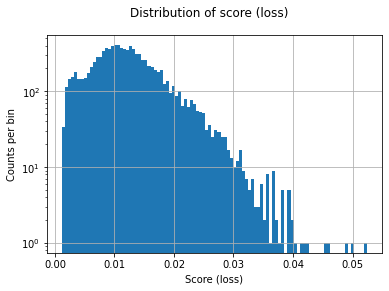

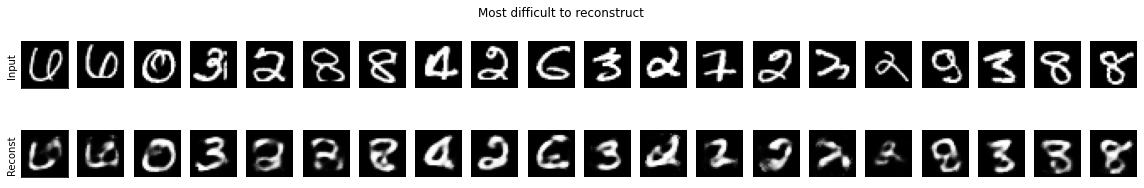

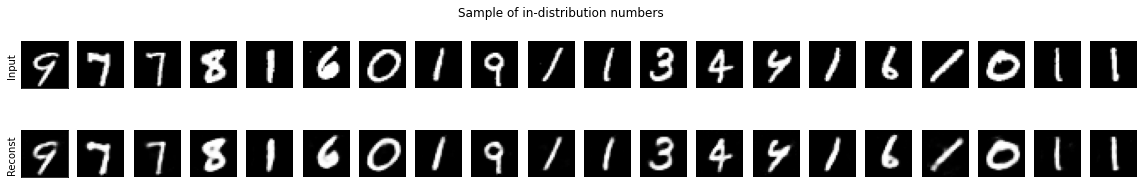

In [8]:
from helpers import anomaly_detection_display

anomaly_detection_display(df)

Each of the bottom panels has the input in the first row and the reconstruction in the second row. 

Let's look at the first of the two panels. If your auto-decoder is sufficiently optimized, the most difficult numbers to reconstruct (the "anomalies" with the highest loss) will look pretty particular: they have some noise (like the vertical lines in some of the numbers), or are just not standard ways of drawing the respective numbers. As a result, the reconstructed images (second row) are not matching the inputs very well and the loss is high. These are anomalies.

The second panel instead shows numbers taken from the peak of the distribution, and look indeed much more standard. The autoencoder can reconstruct them much better which results in a lower loss.

In summary, the reconstruction loss can be used as a score proportional to how much a certain example is typical: a low loss means a typical example; a high loss means an atypical example, an anomaly.

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.